In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
import pickle
import numpy as np
from typing import Tuple
import random
from fastcore.test import test_eq

from multiprocessing.pool import ThreadPool as Pool

import sklearn

from cupid_matching.matching_utils import Matching, _get_singles
from cupid_matching.model_classes import ChooSiowPrimitives
from cupid_matching.choo_siow import entropy_choo_siow
from cupid_matching.min_distance import estimate_semilinear_mde
from cupid_matching.poisson_glm import choo_siow_poisson_glm

from matching_separable_simuls.read_data import get_root_dir, read_margins, read_marriages, \
    rescale_mus, reshape_varcov, remove_zero_cells
from matching_separable_simuls.estimate import generate_bases
from matching_separable_simuls.plots import plot_simulation_results

# matching_separable_simuls

> Simulations for Galichon-Salanie paper on estimating separable matching models

## Install

```sh
pip install matching_separable_simuls
```

## summary

The package reads the marriage patterns from the Choo and Siow 2006 *Journal of Political Economy* paper for the non-reform states of the  1970 wave. It fits a parsimonious homoskedastic logit model. Then it generates `S` datasets from the fitted model, and it uses them to test the estimation methods presented in Galichon-Salanié 2022.

## setting the options

In [ ]:
do_simuls = False
plot_simuls = True

## reading the data

In [ ]:
#| echo: false
data_dir = get_root_dir() / "matching_separable_simuls" / "ChooSiow70nNdata"

In [ ]:
#| echo: false
nx, my = read_margins(data_dir)
muxy, varmus = read_marriages(data_dir)
n_types_men, n_types_women = muxy.shape
mux0, mu0y = _get_singles(muxy, nx, my)
print(f"\nThe data has {n_types_men} types of men and {n_types_women} types of women.")


The data has 25 types of men and 25 types of women.


We reshape the variance-covariance matrix and we normalize the data  to a unit 
total mass of households.

In [ ]:
#| hide
test_eq(muxy[3,4], 16730.0)
test_eq(nx[-1], 84399)
test_eq(my[7], 281192)
test_eq(varmus.shape, (675, 675))

In [ ]:
#| echo: true
# the number of household observations
n_households_obs = 75_265

mus = Matching(muxy, nx, my)
mus_norm = rescale_mus(mus, n_households_obs)

varmus_norm = reshape_varcov(varmus, mus, n_households_obs)

Finally, we add a small number to zero cells:

In [ ]:
mus_norm_fixed = remove_zero_cells(mus_norm) 
muxy_norm_fixed, mux0_norm_fixed, mu0y_norm_fixed, nx_norm_fixed, my_norm_fixed = mus_norm_fixed.unpack()

## fitting a basic model

First we need to generate some basis functions. First we quantile-transform the margins; then we generate orthogonal polynomials on `[0,1]`.   We also create variables `1(x=y)` and `max(x-y, 0)`.

In [ ]:
degrees = [(1,0), (0,1), (2,0), (1,1), (0,2)]
base_functions, base_names = generate_bases(nx_norm_fixed, my_norm_fixed, degrees)
n_bases = base_functions.shape[-1]
print(f"We created {n_bases} bases")

We created 8 bases


### we save the data and the bases we generated

In [ ]:
with open(data_dir / "mus_norm_fixed.pkl", "wb") as f:
    pickle.dump(mus_norm_fixed, f)
with open(data_dir / "varmus_norm.pkl", "wb") as f:
    pickle.dump(varmus_norm, f)
with open(data_dir / "base_functions.pkl", "wb") as f:
    pickle.dump(base_functions, f)

### testing the estimation

In [ ]:
mde_results = estimate_semilinear_mde(
            mus_norm_fixed, base_functions, entropy_choo_siow, 
            more_params=None
        )

estim_Phi = mde_results.estimated_Phi
estim_coeffs = mde_results.estimated_coefficients
std_coeffs = mde_results.stderrs_coefficients

print(mde_results)

********************************************************************************
The data has 75264.99823524455 households

The model has 25x25 margins
      The entropy is parameter-free. 
We use 8 basis functions.

The estimated coefficients (and their standard errors) are

   base 1:     -8.407 ( 0.114)
   base 2:      1.356 ( 0.064)
   base 3:    -17.191 ( 0.576)
   base 4:     -4.236 ( 0.188)
   base 5:      5.984 ( 0.166)
   base 6:     -1.731 ( 0.112)
   base 7:      2.621 ( 0.306)
   base 8:     -0.838 ( 0.140)

Specification test:
   the value of the test statistic is   2168.446
     for a chi2(617), the p-value is      0.000
********************************************************************************



## generating artificial datasets and fitting a homoskedastic logit model

In [ ]:
choo_siow_estim = ChooSiowPrimitives(estim_Phi, nx_norm_fixed, my_norm_fixed)

n_households_sim=n_households_obs
n_sim = 1_000

# generate random seeds
seeds = [None]*n_sim
random.seed(130962)
for i_sim in range(n_sim):
    seeds[i_sim] = random.randrange(100_000)

estim_coeffs_mde = np.zeros((n_sim, estim_coeffs.size))
estim_coeffs_poisson = np.zeros((n_sim, estim_coeffs.size))

def _run_simul(i_sim, seed, n_households_sim, base_functions, entropy_choo_siow):
    mus_sim = choo_siow_estim.simulate(n_households_sim)
    mus_sim_non0 = remove_zero_cells(mus_sim)
    mde_results_sim = estimate_semilinear_mde(
        mus_sim_non0, base_functions, entropy_choo_siow, more_params=None)
    estim_coeffs_mde = mde_results_sim.estimated_coefficients
    poisson_results_sim = choo_siow_poisson_glm(mus_sim_non0, base_functions, verbose = 0)
    estim_coeffs_poisson = poisson_results_sim.estimated_beta
    print(f"Done simul {i_sim}")
    return estim_coeffs_mde, estim_coeffs_poisson


In [ ]:
if do_simuls:
    list_args = [[i_sim, seeds[i_sim], n_households_sim, base_functions, entropy_choo_siow]
                for i_sim in range(n_sim)]

    nb_cpus = 8

    with Pool(nb_cpus) as pool:
        results = pool.starmap(_run_simul, list_args)

    for i_sim in range(n_sim):
        estim_coeffs_mde[i_sim, :] = results[i_sim][0]
        estim_coeffs_poisson[i_sim, :] = results[i_sim][1]

    simul_results = {'Base names': base_names, 'True coeffs': estim_coeffs, 'MDE stderrs': std_coeffs, 
                     'MDE': estim_coeffs_mde, 'Poisson': estim_coeffs_poisson}

    with open(data_dir / f"choosiow_{n_households_sim}.pkl", "wb") as f:
        pickle.dump(simul_results, f)



### we plot the distribution of the estimate

We have a total of 0 outliers for MDE,  out of 1000 simulations.
We have a total of 1 outliers for Poisson,  out of 1000 simulations.
We are discarding 1 outlier samples


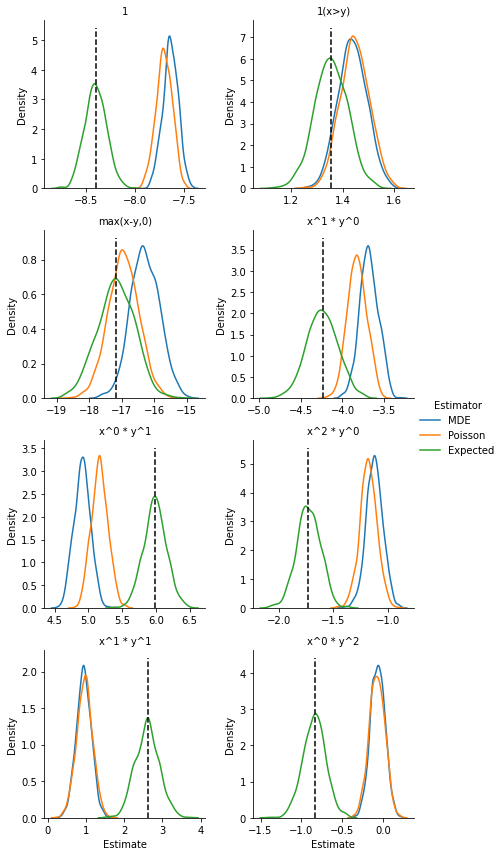

In [ ]:
if plot_simuls:
    plot_simulation_results("choosiow", n_households_sim)

## fitting a nested logit model